In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, f_oneway
import ipywidgets as widgets
from IPython.display import display
import folium
from folium import plugins

In July 2012, in the aftermath of the movie theater massacre in Aurora, Colorado,'Mother Jones' created a first-of-its-kind open-source database documenting mass shootings in the United States. Their research focused on indiscriminate rampages in public places resulting in four or more victims killed by the attacker. This excludes shootings stemming from more conventionally motivated crimes such as armed robbery or gang violence. (Or in which the perpetrators have not been identified.)

We have used this dataset to obtain an understanding of the legality of the weapons held by the attackers and if they had any prior mental illness.

In [2]:
shooting = pd.read_csv('shooting-1982-2023.csv')

In [3]:
shooting.head()

,case,location,date,summary,fatalities,injured,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,...,weapons_obtained_legally,where_obtained,weapon_type,weapon_details,race,gender,latitude,longitude,type,year
0,Nashville religious school shooting,"Nashville, TN",3-27-23,"Audrey Hale, 28, who was a former student at t...",6,1,6,School,28,-,...,-,-,"semiautomatic rifle, semiautomatic handgun",-,-,"F (identified as transgender, per police)",-,-,Mass,2023
1,Michigan State University shooting,"East Lansing, Michigan",2-13-23,"Anthony D. McRae, 43, opened fire at Berkey Ha...",3,5,8,School,43,-,...,yes,-,semiautomatic handguns,-,Black,M,-,-,Mass,2023
2,Half Moon Bay spree shooting,"Half Moon Bay, California",1-23-23,"Chunli Zhao, 67, suspected of carrying out the...",7,1,8,workplace,67,-,...,-,-,semiautomatic handgun,-,Asian,M,-,-,Spree,2023
3,LA dance studio mass shooting,"Monterey Park, California",1-21-23,"Huu Can Tran, 72, fled the scene in a white va...",11,10,21,Other,72,yes,...,-,-,semiautomatic assault weapon (Details pending),-,Asian,M,-,-,Mass,2023
4,Virginia Walmart shooting,"Chesapeake, Virginia",11-22-22,"Andre Bing, 31, who worked as a supervisor at ...",6,6,12,Workplace,31,-,...,-,-,semiautomatic handgun,-,Black,M,-,-,Mass,2022


In [4]:
shooting.shape

(141, 21)

### Data Cleaning

In [5]:
for i in shooting.columns:
    shooting[i].replace({"-":np.nan},inplace=True)

In [6]:
shooting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   case                              141 non-null    object
 1   location                          141 non-null    object
 2   date                              141 non-null    object
 3   summary                           141 non-null    object
 4   fatalities                        141 non-null    int64 
 5   injured                           141 non-null    object
 6   total_victims                     141 non-null    object
 7   location.1                        141 non-null    object
 8   age_of_shooter                    139 non-null    object
 9   prior_signs_mental_health_issues  113 non-null    object
 10  mental_health_details             99 non-null     object
 11  weapons_obtained_legally          124 non-null    object
 12  where_obtained        

In [7]:
shooting.isna().sum()

case                                 0
location                             0
date                                 0
summary                              0
fatalities                           0
injured                              0
total_victims                        0
location.1                           0
age_of_shooter                       2
prior_signs_mental_health_issues    28
mental_health_details               42
weapons_obtained_legally            17
where_obtained                      46
weapon_type                          0
weapon_details                      26
race                                13
gender                               0
latitude                            15
longitude                           15
type                                 0
year                                 0
dtype: int64

In [8]:
shooting['age_of_shooter'] = pd.to_numeric(shooting['age_of_shooter'], errors = 'coerce')
shooting['age_of_shooter'] = shooting['age_of_shooter'].fillna(round(shooting['age_of_shooter'].mean()))

In [9]:
shooting['total_victims'] = pd.to_numeric(shooting['total_victims'], errors = 'coerce')
shooting['total_victims'] = shooting['total_victims'].fillna(round(shooting['total_victims'].mean()))
shooting['injured'] = pd.to_numeric(shooting['injured'], errors = 'coerce')
shooting['injured'] = shooting['injured'].fillna(round(shooting['injured'].mean()))
shooting['fatalities'] = pd.to_numeric(shooting['fatalities'], errors = 'coerce')

In [10]:
shooting['gender'].value_counts()

Male                                         70
M                                            65
Male & Female                                 2
Female                                        2
F (identified as transgender, per police)     1
F                                             1
Name: gender, dtype: int64

In [11]:
shooting['gender'] = shooting['gender'].replace({"M": "Male"})
shooting['gender'] = shooting['gender'].replace({"Male & Female": "Male"})
shooting['gender'] = shooting['gender'].replace({"F (identified as transgender, per police)": "Other"})
shooting['gender'] = shooting['gender'].replace({"F": "Female"})
shooting['gender'].value_counts()

Male      137
Female      3
Other       1
Name: gender, dtype: int64

In [12]:
shooting['prior_signs_mental_health_issues'].value_counts()

Yes         58
Unclear     23
No          17
yes          8
TBD          5
Unknown      1
Unclear      1
Name: prior_signs_mental_health_issues, dtype: int64

In [13]:
replacement_mapping = {
    'TBD': 'Unknown',
    'Unclear ': 'Unknown',
    'Unclear': 'Unknown',
    'yes': 'Yes',
    'yes ': 'Yes',
    ' yes': 'Yes',
    'no': 'No',
    ' no': 'No',
    ' no ': 'No'
}

# Replace values in the 'prior_signs_mental_health_issues' column using the mapping dictionary
shooting['prior_signs_mental_health_issues'] = shooting['prior_signs_mental_health_issues'].replace(replacement_mapping)

shooting['prior_signs_mental_health_issues'] = shooting['prior_signs_mental_health_issues'].fillna(shooting['prior_signs_mental_health_issues'].mode()[0])
shooting['prior_signs_mental_health_issues'].value_counts()

Yes        94
Unknown    30
No         17
Name: prior_signs_mental_health_issues, dtype: int64

In [14]:
shooting['mental_health_details'] = shooting['mental_health_details'].fillna('Unknown')

In [15]:
shooting['weapons_obtained_legally'].value_counts()

Yes                                                                                                                                    81
No                                                                                                                                     16
yes                                                                                                                                     9
TBD                                                                                                                                     7
Unknown                                                                                                                                 6
\nYes                                                                                                                                   2
Kelley passed federal criminal background checks; the US Air Force failed to provide information on his criminal history to the FBI     1
Yes ("some of the weapons were pur

In [16]:
shooting['weapons_obtained_legally'].isna().sum()

17

In [17]:
replacement_mapping = {
    'yes': 'Yes',
    'yes ': 'Yes',
    ' yes': 'Yes',
    '\nYes': 'Yes',
    """Yes ("some of the weapons were purchased legally and some of them may not have been")""": 'Yes',
    'Yes ': 'Yes',
    'no': 'No',
    'no ': 'No',
    ' no': 'No',
    'TBD': 'Unknown',
    'Unknown': 'Unknown',
    "Kelley passed federal criminal background checks; the US Air Force failed to provide information on his criminal history to the FBI": 'Unknown'
}

# Replace values in the 'weapons_obtained_legally' column using the mapping dictionary
shooting['weapons_obtained_legally'] = shooting['weapons_obtained_legally'].replace(replacement_mapping)
shooting['weapons_obtained_legally'].value_counts()

Yes        94
No         16
Unknown    14
Name: weapons_obtained_legally, dtype: int64

In [18]:
shooting['weapons_obtained_legally'] = shooting['weapons_obtained_legally'].fillna(shooting['weapons_obtained_legally'].mode()[0])

In [19]:
shooting['weapons_obtained_legally'].isna().sum()

0

In [20]:
shooting['weapon_details'].isna().sum()

26

In [21]:
shooting['weapon_details'] = shooting['weapon_details'].fillna(shooting['weapon_details'].mode()[0])

In [22]:
shooting['weapon_details'].value_counts()

.45-caliber semiautomatic handgun                                                                                                          28
9mm handgun                                                                                                                                 2
9mm semiautomatic handgun                                                                                                                   2
AR-15                                                                                                                                       2
AK-47-style rifle, per authorities                                                                                                          2
                                                                                                                                           ..
9 mm handgun (ammo used unclear)                                                                                                            1
Zastav

In [23]:
shooting['race'].isna().sum()

13

In [24]:
shooting['race'] = shooting['race'].fillna(shooting['race'].mode()[0])

In [25]:
shooting['race'].value_counts()

white              54
White              31
Black              16
Latino             11
Asian              10
black               9
Other               5
Native American     3
White               1
unclear             1
Name: race, dtype: int64

In [26]:
replacement_mapping = {
   'white': 'White',
    'White ': 'White',
    'black': 'Black',
    'unclear': 'Unclear'
}

# Replace values in the 'weapons_obtained_legally' column using the mapping dictionary
shooting['race'] = shooting['race'].replace(replacement_mapping)
shooting['race'].value_counts()

White              86
Black              25
Latino             11
Asian              10
Other               5
Native American     3
Unclear             1
Name: race, dtype: int64

In [27]:
shooting['where_obtained'].value_counts()

Unknown                                         15
Unclear                                          4
TBD                                              3
Purchased from an individual                     2
Dance's Sporting Goods; Colonial Heights, VA     1
                                                ..
Assembled a rifle out of component parts.        1
Florida Gun Center                               1
Sharpshooters Small Arms Range                   1
Local gun store in Killeen, Guns Galore          1
Garcia Gun Center in Hialeah, Fla.               1
Name: where_obtained, Length: 75, dtype: int64

In [28]:
shooting['where_obtained'] = shooting['where_obtained'].fillna("Unknown")

In [29]:
shooting['where_obtained'].isna().sum()

0

In [30]:
shooting['location.1'].value_counts()

Other          50
Workplace      45
School         22
Religious       7
Military        6
workplace       5
Other\n         3
religious       1
Airport         1
\nWorkplace     1
Name: location.1, dtype: int64

In [31]:
replacement_mapping = {
   'Other\n': 'Other',
    'workplace': 'Workplace',
    '\nWorkplace': 'Workplace',
    'Other\n': 'Other',
    'religious': 'Religious'
}

# Replace values in the 'location.1' column using the mapping dictionary
shooting['location.1'] = shooting['location.1'].replace(replacement_mapping)
shooting['location.1'].value_counts()

Other        53
Workplace    51
School       22
Religious     8
Military      6
Airport       1
Name: location.1, dtype: int64

In [32]:
shooting['state'] = shooting['location'].str.split(",").str[-1].str.strip()

In [33]:
shooting['location'].isna().sum()

0

In [34]:
shooting.isna().sum()

case                                 0
location                             0
date                                 0
summary                              0
fatalities                           0
injured                              0
total_victims                        0
location.1                           0
age_of_shooter                       0
prior_signs_mental_health_issues     0
mental_health_details                0
weapons_obtained_legally             0
where_obtained                       0
weapon_type                          0
weapon_details                       0
race                                 0
gender                               0
latitude                            15
longitude                           15
type                                 0
year                                 0
state                                0
dtype: int64

### Data Analysis

#### Shooting Incidents

In [35]:
# Filter relevant columns for the heatmap and remove rows with NaN values in latitude or longitude
heatmap_data = shooting[['latitude', 'longitude', 'case', 'date', 'fatalities', 'injured', 'location.1', 'type']].dropna(subset=['latitude', 'longitude'])

# Create a base map centered around the US
map_us = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add a HeatMap layer to the map
heatmap_layer = plugins.HeatMap(data=heatmap_data[['latitude', 'longitude']].values, radius=15)
map_us.add_child(heatmap_layer)

# Add tooltips for each shooting incident
for _, row in heatmap_data.iterrows():
    tooltip = f"Case: {row['case']}<br>Date: {row['date']}<br>Fatalities: {row['fatalities']}<br>Injured: {row['injured']}<br>Location: {row['location.1']}<br>Type: {row['type']}"
    folium.Marker([row['latitude'], row['longitude']], tooltip=tooltip).add_to(map_us)

# Display the map
map_us

#### Shooter Analysis

What is the distribution of shooters' ages?

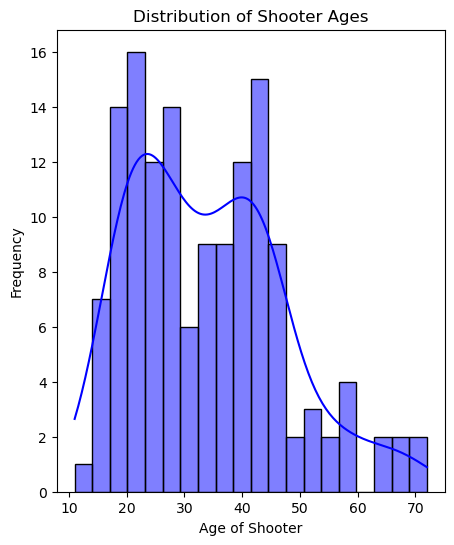

In [36]:
# Distribution of shooter ages
plt.figure(figsize=(5, 6))
sns.histplot(shooting['age_of_shooter'], bins=20, kde=True, color='blue')
plt.title('Distribution of Shooter Ages')
plt.xlabel('Age of Shooter')
plt.ylabel('Frequency')
plt.show()

What is the distribution of shooters' genders?

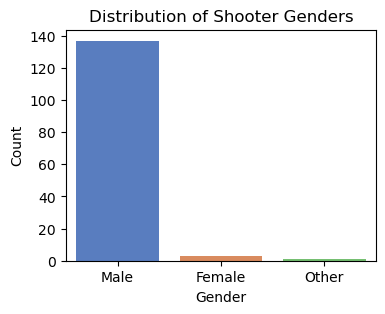

In [37]:
# Distribution of shooter genders
gender_order = shooting['gender'].value_counts().index
plt.figure(figsize = (4, 3))
sns.countplot(x = 'gender', data = shooting, palette = 'muted', order = gender_order)
plt.title('Distribution of Shooter Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

It shows a gender imbalance with men more frequently involved in incidents.

Did the shooters have prior signs of mental health issues?

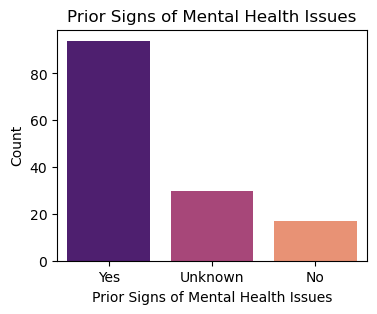

In [38]:
# Prior signs of mental health issues
plt.figure(figsize = (4, 3))
sns.countplot(x ='prior_signs_mental_health_issues', data = shooting, palette = 'magma')
plt.title('Prior Signs of Mental Health Issues')
plt.xlabel('Prior Signs of Mental Health Issues')
plt.ylabel('Count')
plt.show()

The count plot gives us insights into the prevalence of mental health issues among shooters. The plot shows us the majority of the shooters had prior mental health issues.

Were the weapons obtained legally?

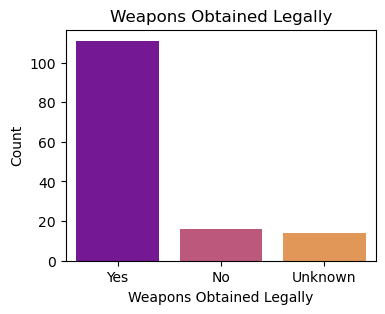

In [39]:
# Weapons obtained legally
plt.figure(figsize=(4, 3))
sns.countplot(x = 'weapons_obtained_legally', data = shooting, palette = 'plasma')
plt.title('Weapons Obtained Legally')
plt.xlabel('Weapons Obtained Legally')
plt.ylabel('Count')
plt.show()

This count plot provides information on the legality of weapons involved and it shows that most of the weapons were obtained legally which is shocking given that majority of the shooters had prior mental health issues. 

#### Location Analysis

What is the distribution of shootings by location type?

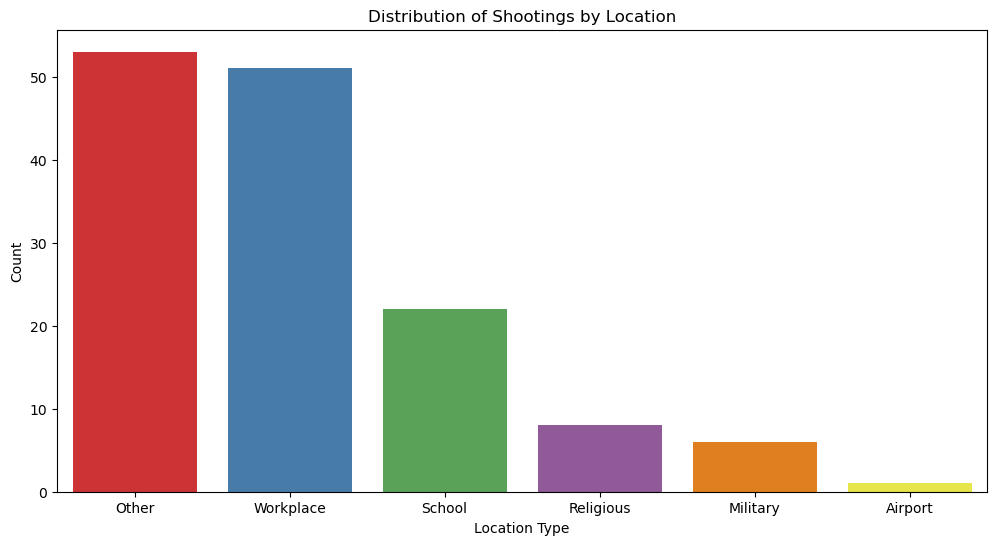

In [40]:
# Distribution of shootings by location
location_order = shooting['location.1'].value_counts().index
plt.figure(figsize=(12, 6))
sns.countplot(x='location.1', data=shooting, palette='Set1', order = location_order)
plt.title('Distribution of Shootings by Location')
plt.xlabel('Location Type')
plt.ylabel('Count')
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Which are the top 5 states with the highest number of shootings?

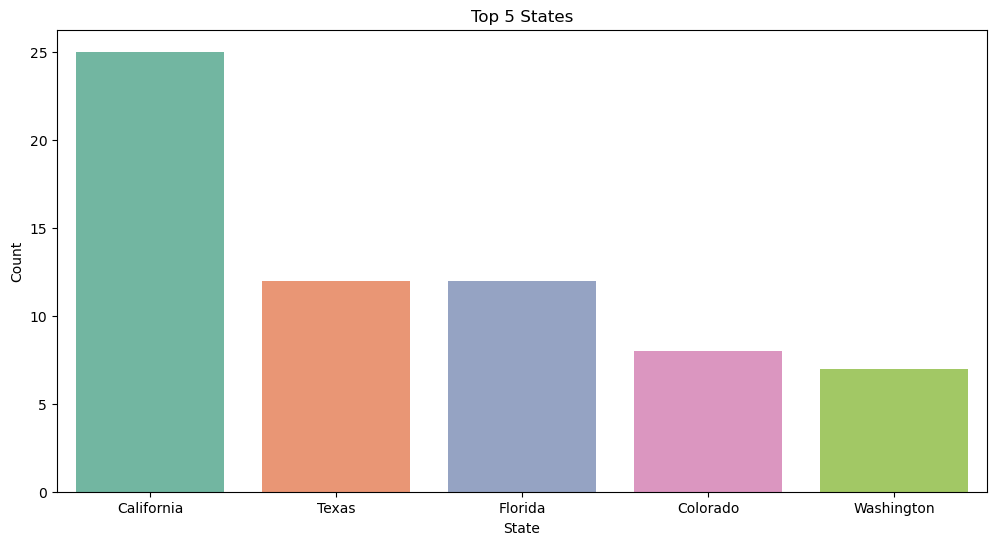

In [41]:
top_5_state = shooting['state'].value_counts().head(5)
plt.figure(figsize=(12, 6))
sns.countplot(x = 'state', data = shooting, order = top_5_state.index, palette = 'Set2')
plt.title('Top 5 States')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

#### Weapon Analysis

In [42]:
location_dropdown = widgets.Dropdown(
    options=['All'] + shooting['location.1'].unique().tolist(),
    value='All',
    description='Location:'
)

# Function to update word cloud based on selected filters
def update_wordcloud(location):
    filtered_data = shooting
    if location != 'All':
        filtered_data = filtered_data[filtered_data['location.1'] == location]

    weapon_details_text = ' '.join(filtered_data['weapon_details'].astype(str))
    wordcloud_details = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(weapon_details_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_details, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Weapon Details\nLocation: {location}')
    plt.show()

# Set up the interactive widgets
interactive_plot = widgets.interactive(update_wordcloud, location = location_dropdown)

# Display the widgets and initial word cloud
display(interactive_plot)

interactive(children=(Dropdown(description='Location:', options=('All', 'School', 'Workplace', 'Other', 'Relig…

The word cloud of weapon details reveal that the most commonly used weapon is the 'semiautomatic handgun'.

#### Mental Health

In [43]:
# Create dropdowns for gender, state, and age range
gender_dropdown = widgets.Dropdown(
    options=['All'] + shooting['gender'].unique().tolist(),
    value='All',
    description='Gender:'
)

state_dropdown = widgets.Dropdown(
    options=['All'] + shooting['state'].unique().tolist(),
    value='All',
    description='State:'
)

age_range_slider = widgets.IntRangeSlider(
    min=shooting['age_of_shooter'].min(),
    max=shooting['age_of_shooter'].max(),
    step=1,
    value=(shooting['age_of_shooter'].min(), shooting['age_of_shooter'].max()),
    description='Age Range:'
)

# Function to update word cloud based on selected filters
def update_wordcloud(gender, state, age_range):
    filtered_data = shooting[shooting['prior_signs_mental_health_issues'] == 'Yes']
    if gender != 'All':
        filtered_data = filtered_data[filtered_data['gender'] == gender]
    if state != 'All':
        filtered_data = filtered_data[filtered_data['state'] == state]
    filtered_data = filtered_data[(filtered_data['age_of_shooter'] >= age_range[0]) & (filtered_data['age_of_shooter'] <= age_range[1])]
    if filtered_data.empty:
        print("No data to display for the selected filters.")
        return
    mental_health_text = ' '.join(filtered_data['mental_health_details'].astype(str))
    wordcloud_types = WordCloud(width=800, height=400, background_color='white', colormap='Accent').generate(mental_health_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_types, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Mental Health Details\nGender: {gender}, State: {state}, Age Range: {age_range[0]}-{age_range[1]}')
    plt.show()

# Set up the interactive widgets
interactive_plot = widgets.interactive(update_wordcloud, gender=gender_dropdown, state=state_dropdown, age_range=age_range_slider)

# Display the widgets and initial word cloud
display(interactive_plot)

interactive(children=(Dropdown(description='Gender:', options=('All', 'Other', 'Male', 'Female'), value='All')…

The word cloud of mental health details reveal that the majority of the shooters had prior mental health issues.

### Impact of Prior Signs of Mental Health on Incident Severity

Hypothesis: Incidents involving individuals with prior signs of mental health issues may result in higher severity.

In [44]:
with_mental_health = shooting[shooting['prior_signs_mental_health_issues'] == 'Yes']
without_mental_health = shooting[shooting['prior_signs_mental_health_issues'] == 'No']

In [45]:
mean_with_mental_health = with_mental_health[['fatalities', 'injured', 'total_victims']].mean()
mean_without_mental_health = without_mental_health[['fatalities', 'injured', 'total_victims']].mean()

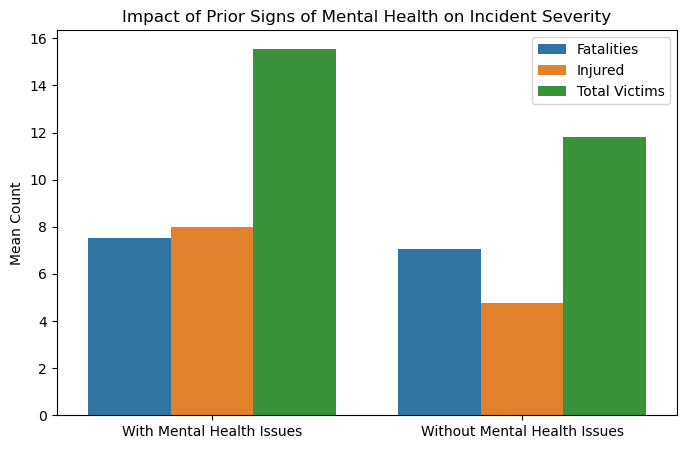

In [46]:
# Visualize mean severity measures
plt.figure(figsize=(8, 5))
sns.barplot(x=['With Mental Health Issues'] * 3 + ['Without Mental Health Issues'] * 3,
            y=list(mean_with_mental_health.values) + list(mean_without_mental_health.values),
            hue=['Fatalities', 'Injured', 'Total Victims'] * 2)
plt.title('Impact of Prior Signs of Mental Health on Incident Severity')
plt.ylabel('Mean Count')
plt.show()

In [47]:
t_stat, p_value = ttest_ind(with_mental_health['total_victims'], without_mental_health['total_victims'])
t_stat, p_value

(1.058713192974961, 0.2920709702754446)

* The t-test results in a p-value of 1.05, which is greater than the common significance level of 0.05. Therefore, we fail to reject the null hypothesis.
* There is insufficient evidence to suggest a significant difference in incident severity between those involving individuals with prior signs of mental health issues and those without.

### Geographical Patterns:

Hypothesis: Incident characteristics may vary by location or state.

In [48]:
state_counts = shooting['state'].value_counts()
location_counts = shooting['location.1'].value_counts()

In [49]:
chi2_stat, p_value, _, _ = chi2_contingency(pd.crosstab(shooting['state'], columns='count'))
chi2_stat, p_value

(0.0, 1.0)

* The chi-square test results in a p-value of 1.0, which is greater than the common significance level of 0.05. Therefore, we fail to reject the null hypothesis.
* There is insufficient evidence to suggest a significant association between incident characteristics and the states or locations.